In [2]:
import numpy as np 
from numpy import random as npr
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
def sigmoid(z):
    return((1 + np.exp(-z))**(-1))

def ReLU(Z):
    return np.maximum(Z, 0)

def regularize(m):
    return(m/np.sum(m))

def weighted_cross_entropy(y, p, m):
    return -sum(m*(y*np.log(p) + (1-y)*np.log(1-p)))

def pFromX(X, seed = 123):
    npr.seed(seed)
    T = X @ npr.randn(D, 7)/1.5
    T += sigmoid(T)
    T -= np.exp(T/5)
    T = T @ npr.randn(T.shape[1], 4)/1.5
    T -= np.tile(T.mean(0), T.shape[0]).reshape(T.shape)
    T /= np.tile(T.std(0), T.shape[0]).reshape(T.shape)/(10)
    p = sigmoid(T.mean(1) - T.mean())
    return p



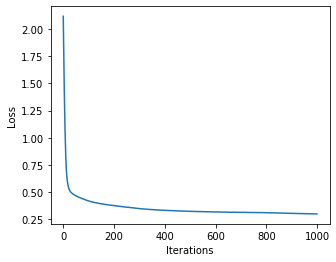

In [150]:
class NN():
    
    def __init__(self, name = None):
        self.name = name
        
    def generate_data(self, N, D, pFromX, seed = 123):
        npr.seed(seed)
        self.N, self.D = N, D
        self.m = np.repeat(1/N, N).reshape(N, 1)
        mu = npr.randn(D) # means
        Sigma = np.eye(D) # covariance
        self.X = npr.multivariate_normal(mu, Sigma, size = N) # get data (X)
        self.latent_p = pFromX(self.X) # get latent P
        self.y = npr.binomial(1, self.latent_p, N).reshape(N, 1) # true outcome values
      
    def add_data(self, X, pFromX, seed = 123):
        npr.seed(seed)
        self.N, self.D = X.shape
        self.m = np.repeat(1/self.N, self.N).reshape(N, 1)
        self.X = X
        self.latent_p = pFromX(X)
        self.y = npr.binomial(1, self.latent_p, N).reshape(N, 1)
        
    def forward_pass(self):
        for layer in range(self.layers):
            if layer == 0: self.Z[layer] = (self.X @ self.W[layer]) + self.B[layer]
            else: self.Z[layer] = (self.A[layer - 1] @ self.W[layer]) + self.B[layer]
            self.A[layer] = self.activations[layer](self.Z[layer]) 
        self.L = weighted_cross_entropy(self.y, self.A[-1], self.m)
        
    def forward_pass_batch(self, batch):
        # data
        self.Xb = self.X[batch]
        self.yb = self.y[batch]
        self.mb = self.m[batch]
        
        # intermediate stuff
        for layer in range(self.layers):
            if layer == 0: self.Zb[layer] = (self.Xb @ self.W[layer]) + self.B[layer]
            if layer !=0: self.Zb[layer] = (self.Ab[layer-1] @ self.W[layer]) + self.B[layer]
            self.Ab[layer] = self.activations[layer](self.Zb[layer])
        # update probs in original 
        self.A[-1][batch] = self.Ab[-1]
        
    def get_derivatives(self, batch):
        # update batch
        self.forward_pass_batch(batch)

        # do last one 
        self.dLdA[-1] = (self.mb*(-self.yb/self.Ab[-1] + (1-self.yb)/(1-self.Ab[-1]))) # (B, 1)
        self.dLdZ[-1] = (self.dLdA[-1] * sigmoid(self.Zb[-1])*(1-sigmoid(self.Zb[-1]))) # (B, 1)
        self.dLdB[-1] = (self.dLdZ[-1].sum(0)) # 1
        self.dLdW[-1] = ((self.dLdZ[-1].T @ self.Ab[-1]).T) # (h, 1)
        self.Wmom[-1] = self.dLdW[-1]
        self.Bmom[-1] = self.dLdB[-1]
        
        # do the rest and do them in reverse
        for layer in range(self.layers-1)[::-1]:

            # change old derivatives to momentum terms 
            self.Wmom[layer] = self.dLdW[layer]
            self.Bmom[layer] = self.dLdB[layer]

            # get derivatives of loss function
            self.dLdA[layer] = self.dLdZ[layer + 1] @ self.W[layer + 1].T 
            self.dLdZ[layer] = self.dLdA[layer] * (self.Zb[layer] > 0) 
            self.dLdB[layer] = self.dLdZ[layer].sum(0)
            if layer == 0: self.dLdW[layer] = (self.dLdZ[layer].T @ self.Xb).T
            else: self.dLdW[layer] = (self.dLdZ[layer].T @ self.Ab[layer-1]).T 

    def update_parameters(self):
        for layer in range(self.layers):
            self.W[layer] -= self.lr*self.dLdW[layer] + self.momentum*self.Wmom[layer]
            self.B[layer] -= self.lr*self.dLdB[layer] + self.momentum*self.Bmom[layer]
    
    def get_loss(self):
        self.L = weighted_cross_entropy(self.y, self.A[-1], self.m)[0]
            
    def instantiate(self):
        self.W = []
        self.B = []
        self.Z = []
        self.A = []
        self.Zb = []
        self.Ab = []
        self.dLdW = []
        self.dLdB = []
        self.dLdZ = []
        self.dLdA = []
        self.Wmom = []
        self.Bmom = []
        
        for layer in range(self.layers):
            
            # get layer and previous layer
            current_h = self.h[layer]
            prev_h = self.prev_h[layer]
            
            # generate random W and B 
            self.W.append(npr.randn(prev_h*current_h).reshape((prev_h, current_h)))
            self.B.append(npr.randn(current_h))
            
            # empty array for Z and A
            self.Z.append(np.empty((self.N, current_h)))
            self.A.append(np.empty((self.N, current_h)))
            self.Zb.append(np.empty((1, current_h)))
            self.Ab.append(np.empty((1, current_h))) # todo: tehse shouldn't be 1s but shoudl be the batch size
            
            # derivatives/momentum for everything (set dLdW and dLdB to 0 so first momentum term is 0)
            self.dLdW.append(np.zeros((prev_h, current_h)))
            self.dLdB.append(np.zeros(current_h))
            self.dLdZ.append(np.empty((self.N, current_h)))
            self.dLdA.append(np.empty((self.N, current_h)))
            self.Wmom.append(np.empty((prev_h, current_h)))
            self.Bmom.append(np.empty((prev_h, current_h)))
            

    def train(self, hidden_layers, h, activations, lr, epochs, batch_size, momentum):
        # add parameters
        self.layers = hidden_layers + 1 # one more for final layer 
        self.prev_h = [self.D] + list(h) # input dimension by layer        
        self.h = list(h) + [1] # output dimension by layer
        self.activations = activations
        self.lr = lr
        self.epochs = epochs 
        self.batch_size = batch_size
        self.momentum = momentum
        
        # instantiate
        self.instantiate()
        
        # fill in A and Z
        self.forward_pass()

        # train by epoch
        self.losses = []
        n_batches = self.N // self.batch_size
        for epoch in range(epochs):
            batch_indices = np.split(npr.permutation(np.arange(self.N)), n_batches)
            for i, batch in enumerate(batch_indices):
                self.get_derivatives(batch)
                self.update_parameters()
            self.get_loss()
            self.losses.append(self.L)
        self.forward_pass() # get output for all observations
        
    def plot_losses(self):
        fig, ax = plt.subplots(figsize = (5, 4))
        sns.lineplot(np.arange(self.epochs), self.losses)
        ax.set(xlabel = 'Iterations', ylabel = 'Loss');
        
    def plot_ps(self):
        fig, ax = plt.subplots(figsize = (5, 4))
        sns.scatterplot(self.latent_p, self.A[-1].reshape(-1))
        sns.lineplot(np.arange(2), np.arange(2))
        ax.set(xlabel = 'latent p', ylabel = 'p');

N, D = 100, 4
hidden_layers, h, lr, epochs, batch_size, momentum = 2, [3,3], 0.01, 1000, 10, 0.01
activations = [ReLU, ReLU, sigmoid]
nn = NN()
nn.generate_data(N, D, pFromX)
nn.train(hidden_layers, h, activations, lr, epochs, batch_size, momentum)
nn.plot_losses()
